In [55]:
import tensorflow as tf
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [12]:
from utils import collect, dataset
from models import lstm, seq2seq

In [62]:
importlib.reload(collect)
importlib.reload(dataset)
importlib.reload(lstm)
importlib.reload(seq2seq)

<module 'models.seq2seq' from '/app/models/seq2seq.py'>

In [162]:
INPUT_WIDTH = 28
LABEL_WIDTH = 8
LAYER_SIZE = 256
DROPOUT = 0.2
EPOCHS = 500
BATCH_SIZE = 64
ATTENTION = True

In [19]:
RMSE = lambda x, y: mean_squared_error(x, y, squared=False)
MAE = mean_absolute_error
MAPE = mean_absolute_percentage_error

In [20]:
def evaluation(y_true, y_pred):
    result = []
    for x, y in zip(y_true, y_pred):
        result.append([
            RMSE(x, y),
            MAE(x, y),
            MAPE(x, y)
        ])
    result = np.array(result)
    result = np.mean(result, axis=0)
    result = np.around(result, 2)
    return result

In [21]:
import pickle

start_date = "20200303"
end_date = "20210708"

covid_fname = f"covid_{start_date}_{end_date}.csv"
scaler_fname = f"covid_{start_date}_{end_date}_scaler.pkl"

# covid_data = collect.get_nation_covid_data(start_date, end_date)
covid_data = pd.read_csv(f"./data/{covid_fname}")

with open(f"./data/{scaler_fname}", "rb") as f:
    scaler = pickle.load(f)

In [22]:
covid_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,5.329140,125851,90296,4159,34,2020-03-03 10:46:53.53,28,4812,35555,85484,62,20200303,00:00,2020-03-03 10:46:53.53
1,4.919986,136707,108293,4750,41,2020-03-04 10:21:44.44,32,5328,28414,102965,63,20200304,00:00,2020-03-04 10:21:44.44
2,4.622748,146541,124731,5255,88,2020-03-05 10:15:12.12,35,5766,21810,118965,64,20200305,00:00,2020-03-05 10:15:12.12
3,4.397235,164740,142908,5643,108,2020-03-06 12:55:44.44,42,6284,21832,136624,65,20200306,00:00,2020-03-06 12:55:44.44
4,4.267543,178189,158569,6134,118,2020-03-07 11:00:45.45,44,6767,19620,151802,66,20200307,00:00,2020-03-07 11:00:45.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,1.517552,10685125,10548828,8444,149614,2021-07-04 09:33:38.815,2026,160084,136297,10388744,562,20210704,00:00,NaN
489,1.521925,10700134,10565241,8723,150044,2021-07-05 09:53:08.163,2028,160795,134893,10404446,563,20210705,00:00,NaN
490,1.524832,10735716,10594017,8749,150760,2021-07-06 09:42:40.275,2032,161541,141699,10432476,564,20210706,00:00,NaN
491,1.531973,10766502,10623754,9220,151500,2021-07-07 09:41:09.863,2033,162753,142748,10461001,565,20210707,00:00,NaN


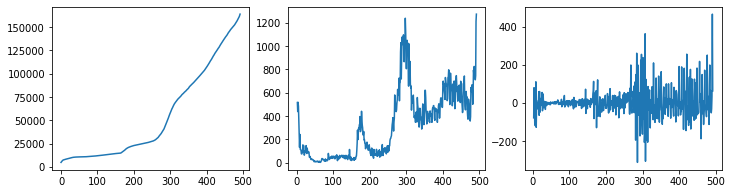

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(covid_data["decideCnt"])
axes[1].plot(covid_data["decideCnt"].diff().dropna())
axes[2].plot(covid_data["decideCnt"].diff().diff().dropna())
plt.show()
plt.close()

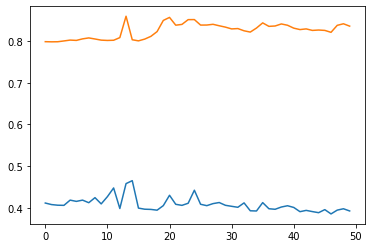

In [163]:
target_data = covid_data[["decideCnt"]].values
target_data = np.diff(target_data, n=2, axis=0)
scaler = StandardScaler()
scaler.fit(target_data)
scaled_data = scaler.transform(target_data)
ds = dataset.DataSlicer(scaled_data, scaled_data, INPUT_WIDTH, LABEL_WIDTH)
lstm_model = lstm.get_model(LAYER_SIZE, LABEL_WIDTH, DROPOUT)
history = lstm_model.fit(ds.train.batch(BATCH_SIZE), validation_data=ds.val.batch(BATCH_SIZE),
                         epochs=50, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.close()

In [164]:
test_inp, test_targ = list(ds.test.batch(ds.test_size))[0]
test_prds = lstm_model(test_inp)

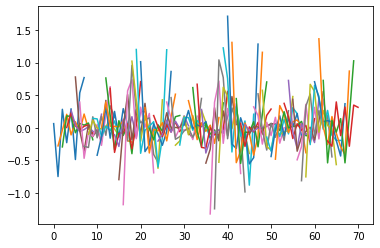

In [165]:
for i, prd in enumerate(test_prds):
    plt.plot(range(i, i+LABEL_WIDTH), prd)
plt.show()
plt.close()

In [166]:
test_targ.shape, test_prds.shape

(TensorShape([64, 8, 1]), TensorShape([64, 8]))

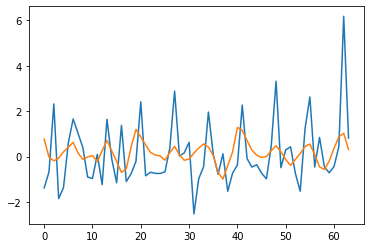

In [168]:
plt.plot(np.diff(test_targ[:, 7], n=0, axis=0))
plt.plot(np.diff(test_prds[:, 7], n=0, axis=0))
plt.show()
plt.close()

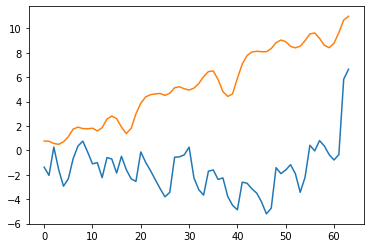

In [170]:
plt.plot(np.cumsum(test_targ[:, 7]))
plt.plot(np.cumsum(test_prds[:, 7]))
plt.show()
plt.close()

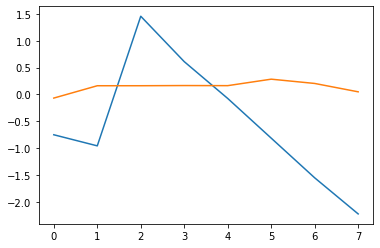

In [173]:
plt.plot(np.cumsum(test_targ[25, :]))
plt.plot(np.cumsum(test_prds[25, :]))
plt.show()
plt.close()